# AI-Powered Clinical Documentation Assistant

## Problem overview

Healthcare professionals face a significant burden from medical documentation. This project focuses on leveraging generative AI to alleviate this burden by automatically extracting structured information from physician-patient audio conversations and using it to pre-fill administrative forms by generating data points that can be electronically stored in EMRs, and EHRS.

We particularly focus on how the below presented workflow can be used to fill a medical history form an audio recording.

This tool outputs data in a FHIR compatible format which ensures seamless integration with existing healthcare systems through a standardized, interoperable format. This structured approach unlocks the data's potential for reusability in various clinical workflows, analytics, and future healthcare applications.

## Solution architecture

This tool implements a RAG-based approach for form/[questionaire](https://www.hl7.org/fhir/R4/questionnaireresponse.html) discovery depending on a users prompt.

It then generates a [QuestionnaireResponse](https://www.hl7.org/fhir/R4/questionnaireresponse.html), which represents an instance of a form submission

In the place of FHIR compatible server we use a json file placeholder to act as a questionnaire repository

[TODO - insert workflow image here preferably landscape]


## Setup

Install packages

In [92]:
!pip uninstall -qqy jupyterlab kfp  # Remove unused conflicting packages
!pip install -q "google-genai==1.7.0" "chromadb==0.6.3" "langchain==0.3.23" "langgraph==0.3.29" "json-repair==0.41.1" "google-api-core==2.24.2" "langchain-google-genai==2.1.2"

**Set up your API key**

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [93]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

In [94]:
from google import genai
from google.genai import types
from google.api_core import retry

from IPython.display import HTML, Markdown, display

client = genai.Client(api_key=GOOGLE_API_KEY)
model_id = "gemini-2.0-flash"

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

## Pre-requisites

**Creating the embedding database with ChromaDB**

We create a [custom function](https://docs.trychroma.com/guides/embeddings#custom-embedding-functions) to generate embeddings with the Gemini API. 

We will use this to store our questionnaire description as documents in the vector database

In [95]:
from chromadb import Documents, EmbeddingFunction, Embeddings

class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model="models/text-embedding-004",
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]

Define a few utils that will be used to load the json questionnaire data. Ideally the data source would be a live FHIR server 

In [96]:
import json

_quest_docs = None
def read_questionnaires_from_fs():
    global _quest_docs
    if _quest_docs is None:
        with open("/kaggle/input/quest-sample-db/quest.db.json", "r") as file:
            _quest_docs = json.loads(file.read())
    return _quest_docs

def get_quest_docs_meta():
    quest_docs = read_questionnaires_from_fs()
    doc_with_metad = []
    doc_ids = []
    for doc in quest_docs:
        doc_id = doc.get("id")
        doc_meta = {
            k: v
            for k, v in {
                "id": doc_id,
                "title": doc.get("title"),
                "name": doc.get("name"),
            }.items()
            if v is not None
        }
        doc_desc = (
            doc.get("description") if doc.get("description") else "No description"
        )
        doc_with_metad.append((doc_desc, doc_meta))
        doc_ids.append(doc_id)
    return doc_with_metad, doc_ids

We now load our questionnaire data and populate the vector database. we store the descriptions as vector embeddings and tag it with some metadata pertaining to each form/questionnaire.

In [97]:
import chromadb

DB_NAME = "fhir-quest-semantic"

embed_fn = GeminiEmbeddingFunction()
chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

def populate_vector_db():
    embed_fn.document_mode = True
    (desc_with_metad, doc_ids) = get_quest_docs_meta()
    descriptions, meta = zip(*desc_with_metad)
    print(meta)

    db.add(documents=list(descriptions), ids=doc_ids, metadatas=list(meta))

populate_vector_db()

({'id': '47004539', 'title': 'AAA New Form'}, {'id': '47004537', 'title': 'ee New Form'}, {'id': '47004533', 'title': 'New Form'}, {'id': 'adc-extraction-test-1', 'title': 'Extraction test - Karnofsky/Lansky Score'}, {'id': '47002099', 'title': 'Demographic Survey', 'name': 'Demographic Survey'}, {'id': '46994390', 'title': 'Extraction test - Karnofsky/Lansky Score'}, {'id': 'health-history-questionnaire-2021-06', 'title': 'Health History Questionnaire (June 2021)'}, {'id': 'routine-obs', 'title': 'Routine Observation Questionnaire', 'name': 'RoutineObservation'}, {'id': 'phq9', 'title': 'Patient Health Questionnaire-9 (PHQ-9)', 'name': 'PHQ9'}, {'id': '46934304', 'name': 'LifelinesQuestionnaire'})


Confirm that the data was inserted by looking at the database

db.count()

## Retrieval: Finding relevant questionnaires

We will be using the user prompt to find a relevant questionnaire to fill. We do so by

1. Querying our vector store for the single top most questionnaire that is semantically related to the users needs
2. Use the gemini model to validate that the questionnaire does actually relate to the users prompt.

In [98]:
def generate_form_validation_prompt(user_prompt, quest_desc, quest_metadata):
    return f"""
# Instruction
You are an evaluator. Your task is to evaluate the relevance of a form description and metadata to a user instruction.
We will provide you with the user instruction, and the form description and metadata.
Read the user instruction carefully to understand the user's need, and then evaluate if the provided form description and metadata are relevant to fulfilling that need based on the Criteria provided in the Evaluation section below.
You will assign the form description a rating following the Rating Rubric

# Evaluation
## Metric Definition
You will be assessing form relevance, which measures whether the provided form description and metadata are suitable for fulfilling the user's instruction.  Relevance implies that a user could likely find the form useful and pertinent to their stated need.

## Criteria
Relevance to User Instruction: The form description and metadata align with the user's instruction and suggest the form could potentially address the user's need.
Usefulness for User Instruction: The form, as described, appears practically useful for a user attempting to follow the given instruction.
Clarity of Description: The form description and metadata are clear and understandable enough to assess relevance. (If description is unclear, down-rate even if potentially relevant).

## Rating Rubric
(YES). The form is very likely to be relevant and useful for the user instruction. The description is clear and strongly suggests a good match.
(NO). The form is not relevant to the user instruction. The description clearly indicates the form is unrelated to the user's need.

# User Inputs and Model Rating
## User Instruction

### Prompt
{user_prompt}

## Form Description and Metadata

### Form Instruction Description
{quest_desc}

### Form Metadata (JSON)
{quest_metadata}
"""

Use JSON mode to control the models output

Define our agent's internal state

In [99]:
import enum


class RelevantRating(enum.Enum):
    YES = "Yes"
    NO = "No"

def discover_questionnaire(query):
    embed_fn.document_mode = False
    result = db.query(query_texts=[query], n_results=1)
    queried_doc_ids = result.get("ids")
    try:
        interest_doc_id = queried_doc_ids[0][0]
    except IndexError:
        return None
    queried_doc_desc = result.get("documents")[0][0]
    queried_doc_meta = result.get("metadatas")[0][0]
    prompt = generate_form_validation_prompt(query, queried_doc_desc, queried_doc_meta)
    print("PRompt", prompt)

    structured_output_config = types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=RelevantRating,
    )
    response = client.models.generate_content(
        model=model_id, contents=[prompt], config=structured_output_config
    )
    parsed_resp = response.parsed

    if parsed_resp is RelevantRating.YES:
        return interest_doc_id
    else:
        return


In [100]:
%pip install -qU "langchain==0.3.23" "langgraph==0.3.29" "json-repair==0.41.1" "langchain-google-genai==2.1.2"

Note: you may need to restart the kernel to use updated packages.


In [101]:
from langchain_core.tools import tool
from typing_extensions import TypedDict, Any, Dict

# Define the state of our graph
class AgentState(TypedDict):
    local_audio_file_path: str
    uploaded_audio_file: Any
    instructions: str
    quest: Dict[str, Any]
    medical_records: Dict[str, Any]
    quest_resp: str
    quest_found: bool
    quest_resp_valid: bool
    soap_note: str
    soap_note_sample: str

In [102]:
def fetch_questionnaire(state: AgentState):
    query = state.get("instructions")
    quest_id = discover_questionnaire(query)

    full_quest_docs = read_questionnaires_from_fs()
    of_interest_quest = None
    for quest in full_quest_docs:
        if quest["id"] == quest_id:
            of_interest_quest = quest
            break
    if of_interest_quest is None:
        return {"quest_found": False}
    else:
        return {"quest_found": True, "quest": of_interest_quest}


We then make make the call to the model with the questionniare that describes the form, and the audio file expecting the qeustionnaire response. The questionnaire response represents the form submission that a physician would have had to make manually from listening or partaking in the recorded conversation.

In [103]:
from json_repair import repair_json

def upload_to_gemini(state: AgentState):
    """Uploads the given file to Gemini."""
    local_file_path = state.get("local_audio_file_path")
    try:
        file = client.files.upload(file=local_file_path)
        return {"uploaded_audio_file": file}
        
    except Exception as e:
        print(e)
        # TODO - what should happen here?
        return {}

def get_questionnaire_response(state: AgentState):
    audio_file = state.get("uploaded_audio_file")
    questionnaire = state.get("quest")
    patient_emr = None # state.get("patient_emr")
    # patient_emr, audio_file, questionnaire, questionnaireRes_example
    prompt = f"""
        You are an audio processing expert with extensive experience in converting audio files into structured data formats, specifically JSON. Your specialty lies in accurately extracting meaningful information from audio recordings and populating questionnaire-style data structures based on that information.
        
        Your task is to analyze the provided audio file and patient Electronic Medical Record (EMR) and fill out the questionnaire with the relevant responses. The output format should follow the structure of the provided questionnaireResponse example.

        Here is the patient EMR:
        {patient_emr}
        
        Here is the questionnaire:
        {questionnaire}
        
        Here is an example questionnaire response:
        {questionnaireRes_example}
        
        Please analyze the audio and generate the appropriate questionnaire response.

        Use this JSON schema:

        QuestionnaireResponse = <generated questionnaireResponse>
        return: QuestionnaireResponse
    """

    response = client.models.generate_content(
        model=model_id,
        contents=[prompt, audio_file],
        config=types.GenerateContentConfig(
            temperature=0,
            response_mime_type='application/json',
        )
    )
    qr = repair_json.loads(response.text)
    return {"quest_resp": qr}


In [104]:
def generate_soap_note_from_audio(state: AgentState):
    patient_emr = None # state.get("patient_emr")
    audio_file = audio_file = state.get("uploaded_audio_file")
    soap_note_sample = state.get("soap_note_sample")
    
    prompt = f"""
    You are a clinical documentation specialist with expertise in converting clinical conversations and EMRs into SOAP notes.

    Your task is to analyze the provided audio file and patient EMR to create a well-structured SOAP note.

    Follow the SOAP format strictly:
    - **Subjective (S):** Patient's stated symptoms and complaints
    - **Objective (O):** Measurable/observable data such as vital signs or physical exam findings
    - **Assessment (A):** Clinical impressions and diagnoses
    - **Plan (P):** Treatment plans, follow-up, and recommendations

    Here is the patient's EMR:
    {patient_emr}

    Here is an example SOAP note:
    {soap_note_sample}

    Please create the SOAP note based on the audio and EMR.
    """

    response = client.models.generate_content(
        model=model_id,
        contents=[prompt, audio_file],
        config=types.GenerateContentConfig(
            temperature=0.1,
        )
    )

    return {"soap_note": response.text}


In [105]:
def evaluate_outputs(state: AgentState):
    # patient_emr, audio_file, questionnaire_response, soap_note, questionnaire_example, soap_example
    patient_emr = None # state.get("patient_emr")
    audio_file = state.get("uploaded_audio_file")
    questionnaire_response = state.get("quest_resp")
    soap_note = state.get("soap_note")
    questionnaire_example = state.get("quest")
    soap_note_sample = state.get("soap_note_sample")

    prompt = f"""
    You are a medical evaluator tasked with reviewing clinical documentation.

    You will evaluate:
    1. The quality and completeness of a **Questionnaire Response**
    2. The accuracy and structure of a **SOAP Note**

    @Lakshay - TODO - what does quality, accuracy and structure look like???
    Use the following scale:
    - 5 = Very Good
    - 4 = Good
    - 3 = Acceptable
    - 2 = Poor
    - 1 = Very Poor
    - 0 = Unusable

    Base your evaluation on:
    - Clinical relevance and coherence
    - Completeness compared to examples
    - Consistency with the patient EMR

    --- Patient EMR (for reference) ---
    {patient_emr}

    --- Audio Transcript of patient and Doctor Conversation (for reference) ---
    {audio_file}

    --- Example Questionnaire Response ---
    {questionnaire_example}

    --- Given Questionnaire Response ---
    {questionnaire_response}

    --- Example SOAP Note ---
    {soap_note_sample}

    --- Given SOAP Note ---
    {soap_note}

    Now provide a rating for each of the following:
    1. Questionnaire Response (0–5):
    2. SOAP Note (0–5):

    Include a one-sentence rationale for each score.
    """

    response = client.models.generate_content(
        model=model_id,
        contents=[prompt],
        config=types.GenerateContentConfig(
            temperature=0,
        )
    )

    return response.text


In [106]:
def truncate_text(text: str, n: int = 50) -> str:
    """Truncates text to the first n characters, adding ellipsis if truncated."""
    if len(text) > n:
        return text[:n] + "..."
    return text

def write_response(state: AgentState):
    """
    Writes a response to the user based on the agent's state, reporting the outcome
    of the workflow.

    This function serves as the reporting node in the LangGraph workflow. It examines
    the AgentState to determine the success or failure

    Args:
        state (AgentState): The current state of the agent, containing information
                            about the workflow execution, including questionnaire
                            response and SOAP note.
    """
    quest_resp = state.get("quest_resp")
    soap_note = state.get("soap_note")
    quest_found = state.get("quest_found")

    if quest_resp is None or soap_note is None:
        error_message = "Workflow encountered an issue."
        if not quest_found:
            error_message += " It appears there was a problem finding relevant questionnaire information. "
        if quest_resp is None:
            error_message += "Questionnaire Response was not generated. "
        if soap_note is None:
            error_message += "SOAP Note was not generated."
        print(error_message)
    else:
        truncated_quest_resp = truncate_text(json.dumps(quest_resp, indent=2))
        truncated_soap_note = truncate_text(soap_note)

        success_message = "Workflow completed successfully!\n\n"
        success_message += "**Questionnaire Response:**\n"
        success_message += truncated_quest_resp + "\n\n"
        success_message += "**SOAP Note:**\n"
        success_message += truncated_soap_note
        print(success_message)

Bring everything together as a graph to execture our workflow

In [107]:
from langchain_google_genai import ChatGoogleGenerativeAI # Correct import path
from langgraph.graph import StateGraph, END, START
from typing import Literal

model = ChatGoogleGenerativeAI(model=model_id, google_api_key=GOOGLE_API_KEY)

# Defined the graph
wk_graph = StateGraph(AgentState)

def aggregate_state(state: StateGraph):
    return state

# node magic strings
audio_file_upload = "upload_file_to_gemini"
disc_fetch_questionnaire = "discover_and_fetch_questionnaire"
gen_quest_resp = "generate_questionnaire_response"
gen_soap_note = "generate_soap_note"
eval_outputs = "evaluate_outputs"
write_resp = "write_resp"
state_aggregator = "state_aggregator"

# Nodes
wk_graph.add_node(audio_file_upload, upload_to_gemini)
wk_graph.add_node(disc_fetch_questionnaire, fetch_questionnaire)
wk_graph.add_node(gen_quest_resp, get_questionnaire_response)
wk_graph.add_node(gen_soap_note, generate_soap_note_from_audio)
wk_graph.add_node(eval_outputs, evaluate_outputs)
wk_graph.add_node(write_resp, write_response)
wk_graph.add_node(state_aggregator, aggregate_state)

def check_file_upload(state: AgentState) -> Literal["state_aggregator", "write_resp"]:
    if state.get("uploaded_audio_file"):
        return state_aggregator
    else:
        return write_resp

def check_quest_to_qr(state:AgentState):
    if state.get("quest_found"):
        return gen_quest_resp
    else:
        return gen_soap_note

# Edges
wk_graph.add_edge(START, audio_file_upload)
wk_graph.add_edge(START, disc_fetch_questionnaire)
wk_graph.add_conditional_edges(audio_file_upload, check_file_upload)
wk_graph.add_edge(disc_fetch_questionnaire, state_aggregator)
wk_graph.add_conditional_edges(state_aggregator, check_quest_to_qr)
wk_graph.add_edge(state_aggregator, gen_soap_note)
wk_graph.add_edge(gen_soap_note, state_aggregator)
wk_graph.add_edge(gen_quest_resp, state_aggregator)
wk_graph.add_edge(state_aggregator, write_resp)
wk_graph.add_edge(write_resp, END)

graph = wk_graph.compile()

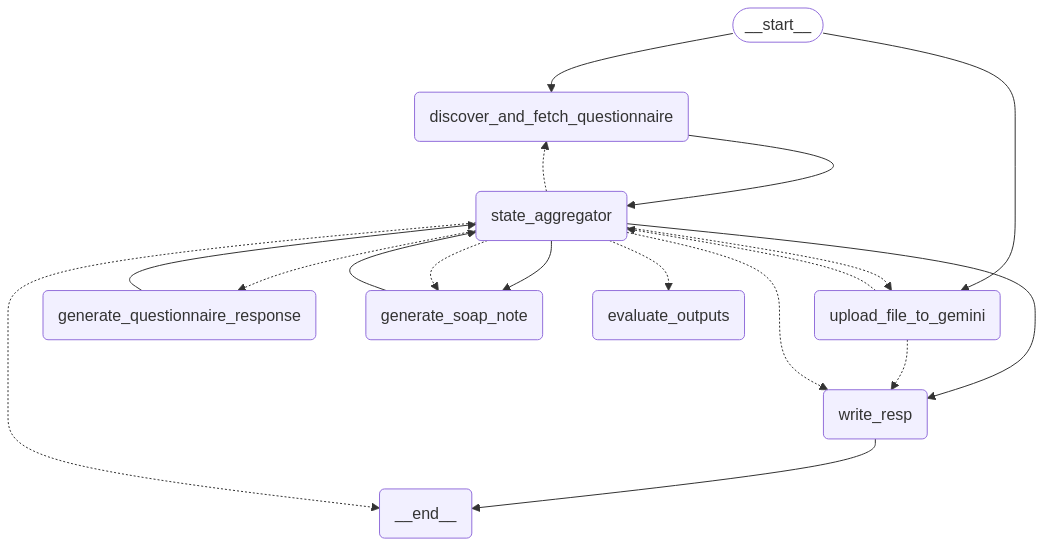

In [108]:
from IPython.display import Image, display

Image(graph.get_graph().draw_mermaid_png())

In [109]:
audio_file_path = '/kaggle/input/quest-sample-db/RES0005.mp3'
# patient_emr_path = '/kaggle/input/conversation/PatientEMR.json'
# soap_ex_path = '/kaggle/input/conversation/soap_example.txt'
# ques_path = '/kaggle/input/conversation/Questionnaire.json'
# qRes_path = '/kaggle/input/conversation/QuestionnaireResponse.json'


# with open(soap_ex_path, 'r') as f:
#     soap_example = f.read()

# with open(patient_emr_path, 'r') as f:
#     patient_emr = f.read()

# with open(ques_path, 'r') as f:
#     questionnaire = f.read()

# with open(qRes_path, 'r') as f:
#     questionnaireRes_example = f.read()

local_input_file_url = "./Data/Audio Recordings/CAR0002.mp3"
inputs = {
    "local_audio_file_path": audio_file_path,
    "instructions": "Fill out a medical history report",
    "soap_note_sample": "",
}
graph.invoke(inputs)

/kaggle/input/quest-sample-db/RES0005.mp3 is not a valid file path.
PRompt 
# Instruction
You are an expert evaluator. Your task is to evaluate the relevance of a form description and metadata to a user instruction.
We will provide you with the user instruction, and the form description and metadata.
Read the user instruction carefully to understand the user's need, and then evaluate if the provided form description and metadata are relevant to fulfilling that need based on the Criteria provided in the Evaluation section below.
You will assign the form description a rating following the Rating Rubric

# Evaluation
## Metric Definition
You will be assessing form relevance, which measures whether the provided form description and metadata are suitable for fulfilling the user's instruction.  Relevance implies that a user could likely find the form useful and pertinent to their stated need.

## Criteria
Relevance to User Instruction: The form description and metadata align with the user's 

ValueError: Must provide state_schema or input and output

In [ ]:
# def main():
#     # File paths
#     audio_file_path = '/kaggle/input/conversation/RES0005.mp3'
#     patient_emr_path = '/kaggle/input/conversation/PatientEMR.json'
#     soap_ex_path = '/kaggle/input/conversation/soap_example.txt'
#     ques_path = '/kaggle/input/conversation/Questionnaire.json'
#     qRes_path = '/kaggle/input/conversation/QuestionnaireResponse.json'
    
#     # Upload only the audio file
#     audio_file = upload_to_gemini(audio_file_path)
#     print(audio_file)

#     with open(soap_ex_path, 'r') as f:
#         soap_example = f.read()
        
#     with open(patient_emr_path, 'r') as f:
#         patient_emr = f.read()
        
#     with open(ques_path, 'r') as f:
#         questionnaire = f.read()

#     with open(qRes_path, 'r') as f:
#         questionnaireRes_example = f.read()

#     questionnaire_response = get_questionnaire_response(patient_emr, audio_file, questionnaire, questionnaireRes_example)
#     print(questionnaire_response)
#     print('-'*100)
#     soap_note = generate_soap_note_from_audio(patient_emr, audio_file, soap_example)
#     print(soap_note)
#     print('-'*100)

# TODO - we currently do not do anything with evaluation
#     evaluation = evaluate_outputs(patient_emr, audio_file, questionnaire_response, soap_note, questionnaireRes_example, soap_example)
#     print(evaluation)

# if __name__ == "__main__":
#     main()